In [7]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import squarify
from collections import Counter
import matplotlib.ticker as mticker

# Set option to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set option to force dataframes to display numbers as floats with thousands separators
pd.set_option('display.float_format', '{:,.3f}'.format)  # Adjust decimal places as needed

# Preprocessing

In [8]:
# -----------------------------------------------------------------------------
# 1. Read & Filter the dataset
# -----------------------------------------------------------------------------

# Define the directory containing the CSV files
directory = 'DS_GlobalTradeAtlas'

# Open the file in a DataFrame for viewing
meat_data_raw_file = os.path.join(directory, 'meat_dataset_yearly.xlsx') # original dataset (YM_meat_qtr_GTAS Forecasting__20_11_2023) renamed for clarity, keeping only the sheet related to the data and the yearly table
df = pd.read_excel(meat_data_raw_file)
import_col = "Import Country/Territory"
export_col = "Export Country/Territory"

# Drop rows where either country is "World Total" (unless both)
condition_keep = (
    ((df[import_col] == "World Total") & (df[export_col] == "World Total"))
    |
    (
        (df[import_col] != "World Total")
        & (df[export_col] != "World Total")
    )
)
df_filtered = df[condition_keep].copy()

print("Original dataset shape:", df.shape)
print("Filtered dataset shape:", df_filtered.shape)


# -----------------------------------------------------------------------------
# 2. Rename columns if they're date-like (e.g. "2005-01-01") to just "2005"
# -----------------------------------------------------------------------------
def rename_column(col):
    try:
        parsed = pd.to_datetime(col)
        return str(parsed.year)
    except Exception:
        return col

df_filtered.rename(columns=rename_column, inplace=True)
print("\nColumns after rename:")
print(df_filtered.columns.tolist())

Original dataset shape: (39034, 42)
Filtered dataset shape: (36258, 42)

Columns after rename:
['Concept', 'Import Country/Territory', 'Export Country/Territory', 'Commodity', 'Start Date', 'End Date', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040']


In [9]:
# -----------------------------------------------------------------------------
# 3. Separate the data into "Total Trade Real Value" vs. "Total Trade Tons"
# -----------------------------------------------------------------------------
year_cols = [str(y) for y in range(2005, 2041)]
id_cols = [import_col, export_col, "Commodity"]

df_val = df_filtered[df_filtered["Concept"] == "Total Trade Real Value"].copy()
df_tons = df_filtered[df_filtered["Concept"] == "Total Trade Tons"].copy()

# Rename year columns in each subset to avoid collisions during merge
for y in year_cols:
    if y in df_val.columns:
        df_val.rename(columns={y: f"{y}_val"}, inplace=True)
    if y in df_tons.columns:
        df_tons.rename(columns={y: f"{y}_tons"}, inplace=True)

In [10]:
# -----------------------------------------------------------------------------
# 4. Merge Value and Tons in wide format
# -----------------------------------------------------------------------------
df_merged = pd.merge(
    df_val,
    df_tons,
    on=id_cols,
    how="outer"  # Change to "inner" if you only want rows that appear in both
)
print("\nShape after merging value and tons:", df_merged.shape)



Shape after merging value and tons: (18129, 81)


In [11]:

# -----------------------------------------------------------------------------
# 5. Melt the merged wide data into long format
# -----------------------------------------------------------------------------
# Identify value and tons columns that exist
value_cols = [f"{y}_val" for y in range(2005, 2041) if f"{y}_val" in df_merged.columns]
tons_cols  = [f"{y}_tons" for y in range(2005, 2041) if f"{y}_tons" in df_merged.columns]

# Melt the value columns
df_val_long = df_merged.melt(
    id_vars=id_cols,
    value_vars=value_cols,
    var_name="Year_val",
    value_name="Trade_Value"
)
# Extract the year from the column name (e.g., "2005_val" -> "2005")
df_val_long["Year"] = df_val_long["Year_val"].str.replace("_val", "", regex=False)

# Melt the tons columns
df_tons_long = df_merged.melt(
    id_vars=id_cols,
    value_vars=tons_cols,
    var_name="Year_tons",
    value_name="Trade_Tons"
)
df_tons_long["Year"] = df_tons_long["Year_tons"].str.replace("_tons", "", regex=False)

# Merge the long value and tons data by id_cols + Year
merge_keys = id_cols + ["Year"]
df_long = pd.merge(
    df_val_long.drop(columns=["Year_val"]),
    df_tons_long.drop(columns=["Year_tons"]),
    on=merge_keys,
    how="outer"
)

# Convert Year to int and create a Date column
df_long["Year"] = df_long["Year"].astype(int)
df_long["Date"] = pd.to_datetime(df_long["Year"].astype(str) + "-01-01")

# At this point, df_long contains all records—even those with invalid data.



Number of invalid year records: 385612
Sample of invalid records:
   Import Country/Territory Export Country/Territory     Commodity  \
0               Afghanistan                Argentina  Beef, frozen   
1               Afghanistan                Argentina  Beef, frozen   
8               Afghanistan                Argentina  Beef, frozen   
9               Afghanistan                Argentina  Beef, frozen   
10              Afghanistan                Argentina  Beef, frozen   

    Trade_Value  Year  Trade_Tons       Date  invalid  
0           NaN  2005         NaN 2005-01-01     True  
1           NaN  2006         NaN 2006-01-01     True  
8           NaN  2013         NaN 2013-01-01     True  
9           NaN  2014         NaN 2014-01-01     True  
10          NaN  2015         NaN 2015-01-01     True  


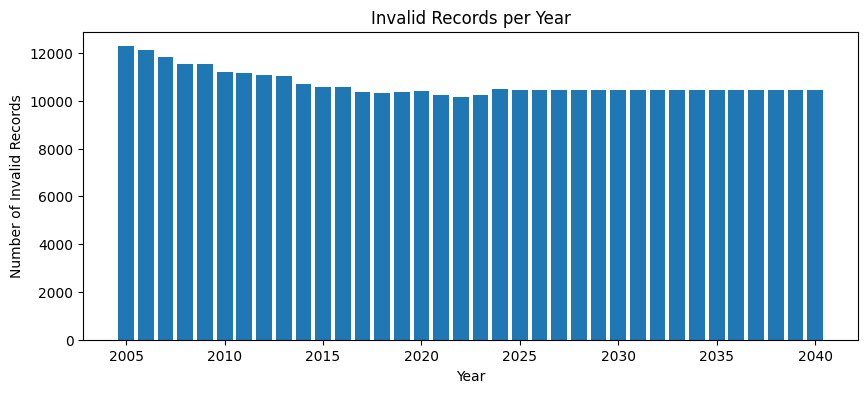

In [12]:
# -----------------------------------------------------------------------------
# 6. Mark and Visualize Invalid Year Records
# -----------------------------------------------------------------------------
def is_invalid(row):
    tv = row["Trade_Value"]
    tt = row["Trade_Tons"]
    # If either is missing, or both missing, mark as invalid
    if pd.isnull(tv) or pd.isnull(tt):
        return True
    # Negative values are invalid
    if tv < 0 or tt < 0:
        return True
    # Zero mismatch: one is zero and the other is positive
    if (tv == 0 and tt > 0) or (tv > 0 and tt == 0):
        return True
    return False

# Apply the function to each row of the long DataFrame
df_long["invalid"] = df_long.apply(is_invalid, axis=1)

# Count and show a sample of invalid rows
num_invalid = df_long["invalid"].sum()
print(f"\nNumber of invalid year records: {num_invalid}")
print("Sample of invalid records:")
print(df_long[df_long["invalid"]].head())

# Visualize the distribution of invalid records per year:
invalid_by_year = df_long.groupby("Year")["invalid"].sum().reset_index()
plt.figure(figsize=(10, 4))
plt.bar(invalid_by_year["Year"], invalid_by_year["invalid"])
plt.xlabel("Year")
plt.ylabel("Number of Invalid Records")
plt.title("Invalid Records per Year")
plt.show()


In [13]:
# -----------------------------------------------------------------------------
# 7. Drop Invalid Records (after inspection)
# -----------------------------------------------------------------------------
df_long_clean = df_long[df_long["invalid"] == False].copy()
print("\nFinal long DataFrame shape after dropping invalid records:", df_long_clean.shape)
print("Final long DataFrame sample:")
df_long_clean.head()


Final long DataFrame shape after dropping invalid records: (267032, 8)
Final long DataFrame sample:


,Import Country/Territory,Export Country/Territory,Commodity,Trade_Value,Year,Trade_Tons,Date,invalid
2,Afghanistan,Argentina,"Beef, frozen","61,728.420",2007,21.096,2007-01-01,False
3,Afghanistan,Argentina,"Beef, frozen","182,225.210",2008,62.276,2008-01-01,False
4,Afghanistan,Argentina,"Beef, frozen","855,800.410",2009,292.471,2009-01-01,False
5,Afghanistan,Argentina,"Beef, frozen","404,814.310",2010,138.346,2010-01-01,False
6,Afghanistan,Argentina,"Beef, frozen","571,717.460",2011,195.385,2011-01-01,False


In [14]:
df_long_clean.describe()

,Trade_Value,Year,Trade_Tons,Date
count,"267,032.000","267,032.000","267,032.000",267032
mean,"16,771,645.970","2,023.031","5,234.119",2023-01-12 09:40:46.735971840
min,0.130,"2,005.000",0.000,2005-01-01 00:00:00
25%,"15,021.812","2,014.000",3.016,2014-01-01 00:00:00
50%,"160,082.265","2,023.000",43.419,2023-01-01 00:00:00
75%,"1,431,502.808","2,032.000",402.240,2032-01-01 00:00:00
max,"40,293,266,554.130","2,040.000","11,572,758.727",2040-01-01 00:00:00
std,"450,037,755.593",10.166,"138,166.310",NaN


In [15]:
# -----------------------------------------------------------------------------
# 8. Split into Actual (≤2022) and Forecast (>2022)
# -----------------------------------------------------------------------------
actual_df = df_long_clean[df_long_clean["Year"] <= 2022].copy()
forecast_df = df_long_clean[df_long_clean["Year"] > 2022].copy()

print("\nActual data range:", actual_df["Date"].min(), "to", actual_df["Date"].max())
if not forecast_df.empty:
    print("Forecast data range:", forecast_df["Date"].min(), "to", forecast_df["Date"].max())


Actual data range: 2005-01-01 00:00:00 to 2022-01-01 00:00:00
Forecast data range: 2023-01-01 00:00:00 to 2040-01-01 00:00:00


# Analysis

Trade value, volume and price evolution

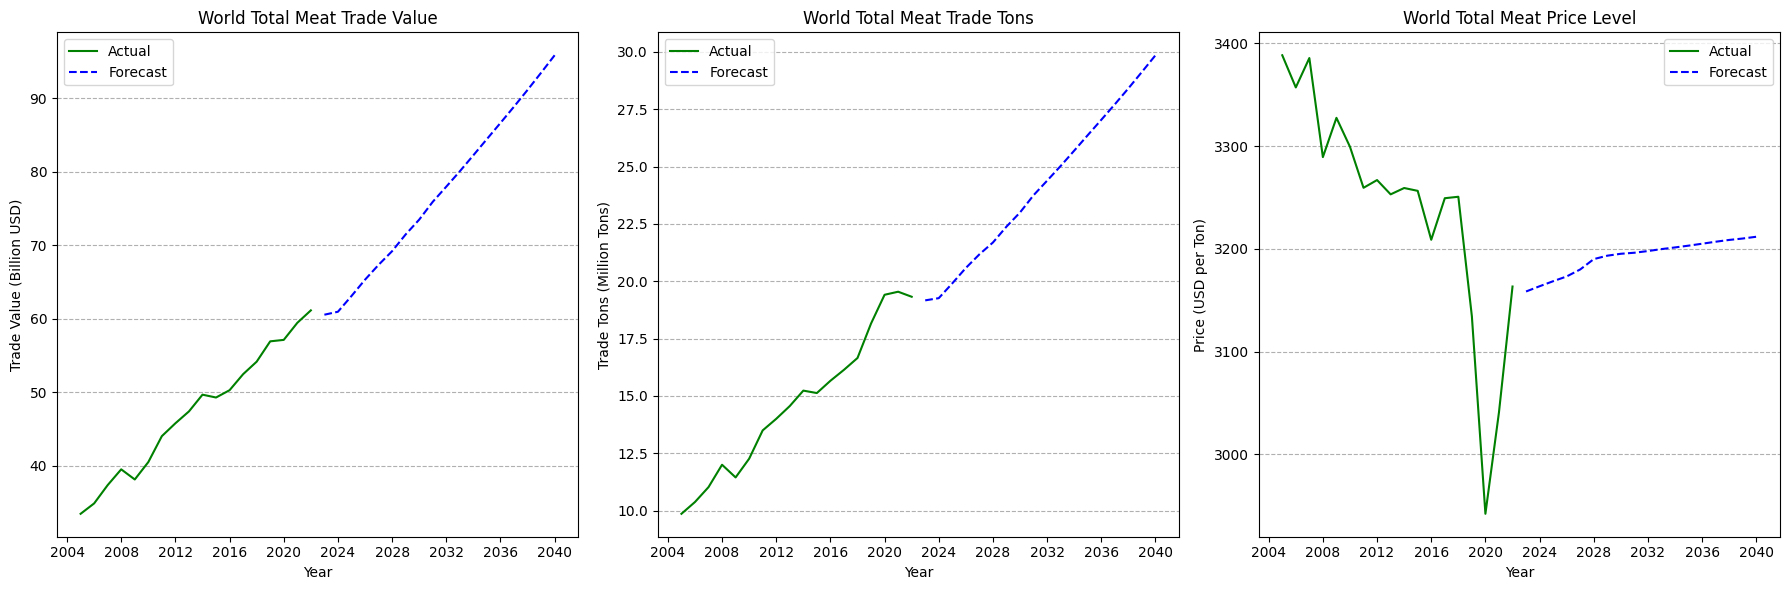

In [16]:
# 1. Combine actual_df and forecast_df into one DataFrame and sort by Date.
df_combined = pd.concat([actual_df, forecast_df], ignore_index=True)
df_combined.sort_values("Date", inplace=True)

# 2. Filter to only rows where both Import and Export Country/Territory are "World Total"
world_total_df = df_combined[
    (df_combined["Import Country/Territory"] == "World Total") & 
    (df_combined["Export Country/Territory"] == "World Total")
]

# 3. Group by Date to aggregate global totals.
grouped = world_total_df.groupby("Date", as_index=False).agg({
    "Trade_Value": "sum",
    "Trade_Tons": "sum"
})

# 4. Compute Price Level (USD per Ton)
grouped["Price_Level"] = grouped["Trade_Value"] / grouped["Trade_Tons"]

# 5. Scale Trade Value to billions and Trade Tons to millions.
grouped["Trade_Value_Billion"] = grouped["Trade_Value"] / 1e9
grouped["Trade_Tons_Million"] = grouped["Trade_Tons"] / 1e6

# 6. Separate actual vs forecast data based on the year.
actual_data = grouped[grouped["Date"].dt.year <= 2022]
forecast_data = grouped[grouped["Date"].dt.year > 2022]

# 7. Create three subplots (Trade Value, Trade Tons, Price Level).
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Plot Trade Value (in Billion USD)
axes[0].plot(
    actual_data["Date"], actual_data["Trade_Value_Billion"],
    color='green', linestyle='-', label='Actual'
)
axes[0].plot(
    forecast_data["Date"], forecast_data["Trade_Value_Billion"],
    color='blue', linestyle='--', label='Forecast'
)
axes[0].set_title("World Total Meat Trade Value")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Trade Value (Billion USD)")
axes[0].grid(axis='y', linestyle='--')
axes[0].legend()

# Plot Trade Tons (in Million Tons)
axes[1].plot(
    actual_data["Date"], actual_data["Trade_Tons_Million"],
    color='green', linestyle='-', label='Actual'
)
axes[1].plot(
    forecast_data["Date"], forecast_data["Trade_Tons_Million"],
    color='blue', linestyle='--', label='Forecast'
)
axes[1].set_title("World Total Meat Trade Tons")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Trade Tons (Million Tons)")
axes[1].grid(axis='y', linestyle='--')
axes[1].legend()

# Plot Price Level (USD per Ton)
axes[2].plot(
    actual_data["Date"], actual_data["Price_Level"],
    color='green', linestyle='-', label='Actual'
)
axes[2].plot(
    forecast_data["Date"], forecast_data["Price_Level"],
    color='blue', linestyle='--', label='Forecast'
)
axes[2].set_title("World Total Meat Price Level")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Price (USD per Ton)")
axes[2].grid(axis='y', linestyle='--')
axes[2].legend()

plt.tight_layout()
plt.show()

Concentration analysis

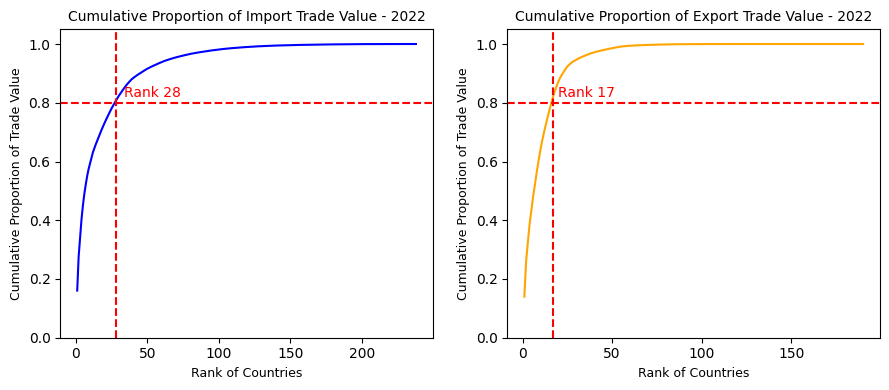

In [12]:
def plot_concentration_analysis(df_year, year_label):
    threshold = 0.8  # 80% threshold

    # --- Aggregate by Importers ---
    import_agg = df_year.groupby("Import Country/Territory")["Trade_Value"].sum().reset_index()
    import_agg = import_agg.sort_values("Trade_Value", ascending=False).reset_index(drop=True)
    import_agg["Cumulative"] = import_agg["Trade_Value"].cumsum()
    total_import = import_agg["Trade_Value"].sum()
    import_agg["CumulativeProp"] = import_agg["Cumulative"] / total_import
    import_agg["Rank"] = import_agg.index + 1

    # --- Aggregate by Exporters ---
    export_agg = df_year.groupby("Export Country/Territory")["Trade_Value"].sum().reset_index()
    export_agg = export_agg.sort_values("Trade_Value", ascending=False).reset_index(drop=True)
    export_agg["Cumulative"] = export_agg["Trade_Value"].cumsum()
    total_export = export_agg["Trade_Value"].sum()
    export_agg["CumulativeProp"] = export_agg["Cumulative"] / total_export
    export_agg["Rank"] = export_agg.index + 1

    # --- Figure with two subplots: Imports (left), Exports (right) ---
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # ==================== IMPORT PLOT ====================
    axes[0].plot(import_agg["Rank"], import_agg["CumulativeProp"], color='blue')
    axes[0].set_title(f"Cumulative Proportion of Import Trade Value - {year_label}", fontsize = 10)
    axes[0].set_xlabel("Rank of Countries", fontsize = 9)
    axes[0].set_ylabel("Cumulative Proportion of Trade Value", fontsize = 9)
    axes[0].set_ylim(0, 1.05)

    # Find rank for 80% threshold in imports
    imp_above_thresh = import_agg[import_agg["CumulativeProp"] >= threshold]
    if not imp_above_thresh.empty:
        rank_80_imp = imp_above_thresh["Rank"].iloc[0]
        axes[0].axhline(y=threshold, color='red', linestyle='--')
        axes[0].axvline(x=rank_80_imp, color='red', linestyle='--')
        # Add an (x_offset, y_offset) so text doesn't overlap the line
        x_offset = 6
        y_offset = 0.01
        axes[0].text(
            rank_80_imp + x_offset,
            threshold + y_offset,
            f"Rank {rank_80_imp}",
            color='red',
            va='bottom',
            ha='left'
        )

    # ==================== EXPORT PLOT ====================
    axes[1].plot(export_agg["Rank"], export_agg["CumulativeProp"], color='orange')
    axes[1].set_title(f"Cumulative Proportion of Export Trade Value - {year_label}", fontsize = 10)
    axes[1].set_xlabel("Rank of Countries", fontsize = 9)
    axes[1].set_ylabel("Cumulative Proportion of Trade Value", fontsize = 9)
    axes[1].set_ylim(0, 1.05)

    # Find rank for 80% threshold in exports
    exp_above_thresh = export_agg[export_agg["CumulativeProp"] >= threshold]
    if not exp_above_thresh.empty:
        rank_80_exp = exp_above_thresh["Rank"].iloc[0]
        axes[1].axhline(y=threshold, color='red', linestyle='--')
        axes[1].axvline(x=rank_80_exp, color='red', linestyle='--')
        # Same offset logic for the export plot
        x_offset = 3
        y_offset = 0.01
        axes[1].text(
            rank_80_exp + x_offset,
            threshold + y_offset,
            f"Rank {rank_80_exp}",
            color='red',
            va='bottom',
            ha='left'
        )

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.show()

# ----------------------------------------------------------------------
# EXAMPLE USAGE FOR ACTUAL AND FORECAST
# ----------------------------------------------------------------------
# 1) Identify last year in actual_df, remove 'World Total' rows, and plot
last_year_actual = actual_df["Date"].dt.year.max()
actual_last_year_df = actual_df[actual_df["Date"].dt.year == last_year_actual].copy()

mask_world = (
    (actual_last_year_df["Import Country/Territory"] == "World Total") |
    (actual_last_year_df["Export Country/Territory"] == "World Total")
)
actual_last_year_df = actual_last_year_df[~mask_world]

if not actual_last_year_df.empty:
    plot_concentration_analysis(actual_last_year_df, f"{last_year_actual}")
else:
    print(f"No data for Actual {last_year_actual} after removing 'World Total'.")

# # 2) Same for forecast_df (if not empty)
# if not forecast_df.empty:
#     last_year_forecast = forecast_df["Date"].dt.year.max()
#     forecast_last_year_df = forecast_df[forecast_df["Date"].dt.year == last_year_forecast].copy()

#     mask_world_forecast = (
#         (forecast_last_year_df["Import Country/Territory"] == "World Total") |
#         (forecast_last_year_df["Export Country/Territory"] == "World Total")
#     )
#     forecast_last_year_df = forecast_last_year_df[~mask_world_forecast]

#     if not forecast_last_year_df.empty:
#         plot_concentration_analysis(forecast_last_year_df, f"Forecast {last_year_forecast}")
#     else:
#         print(f"No data for Forecast {last_year_forecast} after removing 'World Total'.")
# else:
#     print("No forecast data to analyze.")

Plot proportion of global trade value by the 17 major exporters

Major exporters (80% cutoff from last actual year): ['Brazil', 'United States', 'Germany', 'Spain', 'Netherlands', 'Thailand', 'India', 'Denmark', 'Poland', 'Australia', 'Canada', 'China (mainland)', 'Italy', 'New Zealand', 'Argentina', 'Ireland', 'France']


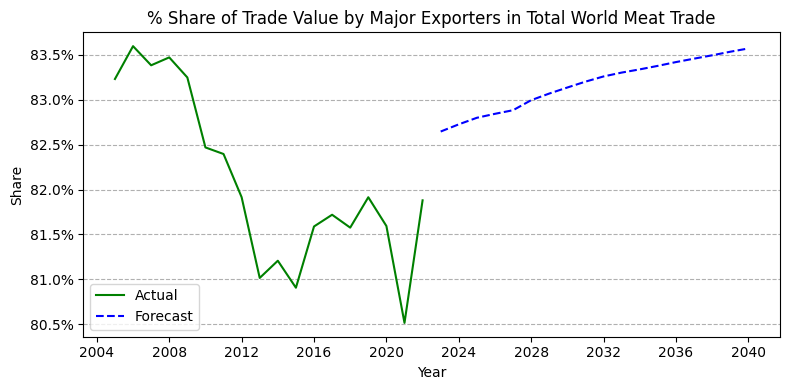

In [15]:
# Build function to list the major exporters representing 80% of global trade
def identify_major_exporters_last_year(actual_df, threshold=0.8):
    """
    Identifies a set of exporters (country->country only) in the last year of actual_df
    whose cumulative sum of exports reaches 80% of the total in that year.
    Returns a list of exporter names.
    """
    # 1) Find the last year in actual_df
    last_year = actual_df["Year"].max()

    # 2) Filter for that year, country->country only
    mask_last_year_cty_cty = (
        (actual_df["Year"] == last_year) &
        (actual_df["Export Country/Territory"] != "World Total") &
        (actual_df["Import Country/Territory"] != "World Total")
    )
    last_year_cty_cty = actual_df[mask_last_year_cty_cty].copy()

    # 3) Sum trade value by exporter
    exporter_agg = last_year_cty_cty.groupby("Export Country/Territory")["Trade_Value"].sum().reset_index()
    exporter_agg = exporter_agg.sort_values("Trade_Value", ascending=False).reset_index(drop=True)

    # 4) Compute cumulative proportion
    total_export_last_year = exporter_agg["Trade_Value"].sum()
    exporter_agg["Cumulative"] = exporter_agg["Trade_Value"].cumsum()
    exporter_agg["CumulativeProp"] = exporter_agg["Cumulative"] / total_export_last_year

    # 5) Select top exporters until we cross threshold=0.8
    major_exporters = []
    for idx, row in exporter_agg.iterrows():
        major_exporters.append(row["Export Country/Territory"])
        if row["CumulativeProp"] >= threshold:
            break

    return major_exporters

def compute_portion_major_exporters(df, major_exporters):
    """
    For each year in df, computes:
       Numerator = sum of (major exporter -> any country) flows (country->country only),
       Denominator = single row "World Total -> World Total" for that year.
    Returns a DataFrame with columns ["Year", "Portion"].
    """
    years = sorted(df["Year"].unique())
    portion_list = []

    for y in years:
        # Numerator: sum of flows from major exporters, country->country in year y
        mask_num = (
            (df["Year"] == y) &
            (df["Export Country/Territory"].isin(major_exporters)) &
            (df["Export Country/Territory"] != "World Total") &
            (df["Import Country/Territory"] != "World Total")
        )
        numerator = df.loc[mask_num, "Trade_Value"].sum()

        # Denominator: the single row where both columns = "World Total"
        mask_den = (
            (df["Year"] == y) &
            (df["Export Country/Territory"] == "World Total") &
            (df["Import Country/Territory"] == "World Total")
        )
        denominator = df.loc[mask_den, "Trade_Value"].sum()

        portion = None
        if denominator > 0:
            portion = numerator / denominator

        portion_list.append({"Year": y, "Portion": portion})

    portion_df = pd.DataFrame(portion_list)
    return portion_df

# -------------------------------------------------------------------------
# Build Plot
# -------------------------------------------------------------------------
# 1) Ensure actual_df and forecast_df each have a "Year" column of type int
#    e.g.: actual_df["Year"] = actual_df["Date"].dt.year.astype(int)
#          forecast_df["Year"] = forecast_df["Date"].dt.year.astype(int)

# 2) Identify major exporters from the last year in actual_df
major_exporters_80 = identify_major_exporters_last_year(actual_df, threshold=0.8)
print("Major exporters (80% cutoff from last actual year):", major_exporters_80)

# 3) Compute portion time series for actual and forecast
actual_portion_df = compute_portion_major_exporters(actual_df, major_exporters_80)
forecast_portion_df = compute_portion_major_exporters(forecast_df, major_exporters_80) if not forecast_df.empty else pd.DataFrame(columns=["Year","Portion"])

# 4) Plot both lines on the same figure
fig, ax = plt.subplots(figsize=(8, 4))

# a) Actual portion: green solid line, no markers
ax.plot(
    actual_portion_df["Year"], actual_portion_df["Portion"],
    color='green', linestyle='-', label='Actual', marker=None
)

# b) Forecast portion: blue dashed line, no markers
if not forecast_portion_df.empty:
    ax.plot(
        forecast_portion_df["Year"], forecast_portion_df["Portion"],
        color='blue', linestyle='--', label='Forecast', marker=None
    )

# 5) Formatting
ax.set_title("% Share of Trade Value by Major Exporters in Total World Meat Trade")
ax.set_xlabel("Year")
ax.set_ylabel("Share")
ax.grid(axis='y', linestyle='--')  # dashed horizontal grid
ax.legend()

# Force integer ticks on x-axis
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Format y-axis as percentages with 1 decimal place
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))

plt.tight_layout()
plt.show()

Function to build Network Edges from Major Exporters (over entire period)

In [16]:
############################################################################
# Build Network Edges from These Major Exporters (over entire period)
############################################################################

def build_network_edges(df, major_exporters):
    mask = df["Export Country/Territory"].isin(major_exporters)
    df_edges = df[mask].copy()
    agg_edges = df_edges.groupby(["Export Country/Territory", "Import Country/Territory"])["Trade_Value"].sum().reset_index()
    agg_edges.rename(columns={
        "Export Country/Territory": "Exporter",
        "Import Country/Territory": "Importer",
        "Trade_Value": "Edge_Weight"
    }, inplace=True)
    return agg_edges

Functions to plot Cumulative Distributions (Edge Weight & Node Import)

In [ ]:
############################################################################
# 3. Plot Cumulative Distributions (Edge Weight & Node Import)
############################################################################

def plot_cumulative_distribution_of_edges(agg_edges, dataset_label=""):
    edges_sorted = agg_edges.sort_values("Edge_Weight", ascending=False).reset_index(drop=True)
    total_weight = edges_sorted["Edge_Weight"].sum()
    edges_sorted["Cumulative"] = edges_sorted["Edge_Weight"].cumsum()
    edges_sorted["CumulativeProp"] = edges_sorted["Cumulative"] / total_weight
    edges_sorted["Rank"] = edges_sorted.index + 1
    
    fig, ax = plt.subplots(figsize=(6,5))
    
    ax.plot(edges_sorted["Rank"], edges_sorted["CumulativeProp"], color='blue')
    ax.set_title(f"Cumulative Distribution of Edge Weight - {dataset_label}")
    ax.set_xlabel("Edge Weight Rank")
    ax.set_ylabel("Cumulative Proportion")
    ax.set_ylim(0,1.05)
    
    threshold = 0.9
    crossing = edges_sorted[edges_sorted["CumulativeProp"] >= threshold].head(1)
    
    if not crossing.empty:
        rank_90 = crossing["Rank"].iloc[0]
        ax.axvline(x=rank_90, color='red', linestyle='--')
        ax.axhline(y=threshold, color='red', linestyle='--')
        ax.text(rank_90+2, threshold, f"Rank {rank_90}", color='red')
    
    plt.tight_layout()
    plt.show()

def plot_cumulative_distribution_of_node_import(agg_edges, dataset_label=""):
    node_import = agg_edges.groupby("Importer")["Edge_Weight"].sum().reset_index()
    node_import.rename(columns={"Importer": "Node", "Edge_Weight": "Import_Weight"}, inplace=True)
    node_import = node_import.sort_values("Import_Weight", ascending=False).reset_index(drop=True)
    total_import = node_import["Import_Weight"].sum()
    node_import["Cumulative"] = node_import["Import_Weight"].cumsum()
    node_import["CumulativeProp"] = node_import["Cumulative"] / total_import
    node_import["Rank"] = node_import.index + 1
    
    fig, ax = plt.subplots(figsize=(6,5))
    
    ax.plot(node_import["Rank"], node_import["CumulativeProp"], color='blue')
    ax.set_title(f"Cumulative Distribution of Node Import - {dataset_label}")
    ax.set_xlabel("Node Weight Rank")
    ax.set_ylabel("Cumulative Proportion")
    ax.set_ylim(0,1.05)
    
    threshold = 0.9
    crossing = node_import[node_import["CumulativeProp"] >= threshold].head(1)
    
    if not crossing.empty:
        rank_90 = crossing["Rank"].iloc[0]
        ax.axvline(x=rank_90, color='red', linestyle='--')
        ax.axhline(y=threshold, color='red', linestyle='--')
        ax.text(rank_90+2, threshold, f"Rank {rank_90}", color='red')
    
    plt.tight_layout()
    plt.show()

Function to prune edges at 90% Cumulative Weight

In [18]:
############################################################################
# Prune Edges at 90% Cumulative Weight
############################################################################

def prune_edges(agg_edges, quantile=0.9):
    edges_sorted = agg_edges.sort_values("Edge_Weight", ascending=False).reset_index(drop=True)
    total_weight = edges_sorted["Edge_Weight"].sum()
    edges_sorted["Cumulative"] = edges_sorted["Edge_Weight"].cumsum()
    edges_sorted["CumulativeProp"] = edges_sorted["Cumulative"] / total_weight
    pruned_edges = edges_sorted[edges_sorted["CumulativeProp"] <= quantile].copy()
    return pruned_edges

Function to build and plot Directed Graph (Spring Layout, Node Size by Node Strength)

In [53]:
############################################################################
# Build and Plot Directed Graph (Spring Layout, Node Size by Node Strength)
############################################################################

def build_and_plot_directed_graph(G, major_exporters, dataset_label=""):
    # Compute node strength: sum of weights on all incident edges.
    node_strength = {}
    for node in G.nodes():
        in_w = sum(data.get("Edge_Weight", 0) for _,_,data in G.in_edges(node, data=True))
        out_w = sum(data.get("Edge_Weight", 0) for _,_,data in G.out_edges(node, data=True))
        node_strength[node] = in_w + out_w
    max_strength = max(node_strength.values()) if node_strength else 1
    if max_strength == 0:
        node_sizes = [200 for n in G.nodes()]
    else:
        node_sizes = [200 + (node_strength[n] / max_strength)*2000 for n in G.nodes()]
    
    # Use softer colors: major exporters in 'salmon', others in 'skyblue'.
    node_colors = {n: 'salmon' if n in major_exporters else 'skyblue' for n in G.nodes()}
    colors = [node_colors[n] for n in G.nodes()]
    
    # Scale edge widths using "Edge_Weight"
    edges_data = G.edges(data=True)
    weights = [edata['Edge_Weight'] for (_,_,edata) in edges_data]
    max_w_edge = max(weights) if weights else 1
    edge_widths = [(w / max_w_edge)*5 for w in weights]
    pos = nx.spring_layout(G, k=1.0, seed=42)
    plt.figure(figsize=(12,8))
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=edge_widths, arrowstyle='->', arrowsize=10, edge_color='gray', alpha=0.6)
    label_options = {'font_size': 8, 'bbox': dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)}
    nx.draw_networkx_labels(G, pos, **label_options)
    plt.title(f"Pruned Meat Trade Network \n(Node size ~ Node Strength)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return G

Function to analyze Out-Degree and In-Degree Distribution: Bar Chart & Treemap

In [20]:
#####################################################################################################
# Analyze Out-Degree (for exporters) In-Degree (for importers) distribution
#####################################################################################################

def analyze_in_degree_and_treemap(G, dataset_label=""):
    in_deg = dict(G.in_degree())
    deg_count = Counter(in_deg.values())
    deg_items = sorted(deg_count.items())  # list of (in_degree, count)
    degrees, counts = zip(*deg_items)
    num_categories = len(deg_items)
    cmap = plt.get_cmap('tab20', num_categories)
    bar_colors = [cmap(i) for i in range(num_categories)]
    fig, ax = plt.subplots(figsize=(7,5))
    ax.bar(degrees, counts, color=bar_colors, width=0.7)
    ax.set_xlabel("In-Degree")
    ax.set_ylabel("Number of Territories")
    ax.set_title(f"In-Degree Distribution (Bar Chart) - {dataset_label}")
   
    plt.tight_layout()
    plt.show()
    
    labels = [f"InDeg {deg}\n({cnt})" for deg, cnt in deg_items]
    sizes = list(counts)
    
    plt.figure(figsize=(8,6))
    squarify.plot(sizes=sizes, label=labels, color=bar_colors, alpha=0.8)
    plt.title(f"In-Degree Distribution (Treemap) - {dataset_label}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_out_degree_table(G, major_exporters, dataset_label=""):
    out_deg = dict(G.out_degree())
    table_data = [{"Major Exporter": exp, "Out-degree": out_deg.get(exp, 0)} for exp in major_exporters]
    df_outdeg = pd.DataFrame(table_data).sort_values("Out-degree", ascending=False)
    print(f"\nOut-Degree Table for Major Exporters - {dataset_label}")
    print(df_outdeg.to_string(index=False))

def show_in_degree_table(G, top_n=10, dataset_label=""):
    in_deg = dict(G.in_degree())
    filtered = {k: v for k, v in in_deg.items() if v > 0}
    sorted_indeg = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    top_importers = sorted_indeg[:top_n]
    df_indeg = pd.DataFrame(top_importers, columns=["Major Importer", "In-degree"])
    print(f"\nIn-Degree Table for Major Importers - {dataset_label}")
    print(df_indeg.to_string(index=False))

Function to simplify dependency analysis (at 50% threshold)

In [54]:
############################################################################
# Dependency Analysis (>50% threshold)
############################################################################

def run_dependency_analysis(G, major_exporters, dataset_label=""):
    in_edges_by_importer = {}
    for u, v, data in G.edges(data=True):
        w = data["Edge_Weight"]
        in_edges_by_importer.setdefault(v, 0)
        in_edges_by_importer[v] += w
    dep_edges = []
    
    for u, v, data in G.edges(data=True):
        w = data["Edge_Weight"]
        total_import_v = in_edges_by_importer[v]
        if total_import_v > 0 and (w / total_import_v) > 0.5:
            dep_edges.append((u, v, w))
    G_dep = nx.DiGraph()
    G_dep.add_nodes_from(G.nodes())
    
    for (u, v, w) in dep_edges:
        G_dep.add_edge(u, v, Edge_Weight=w)
    
    plt.figure(figsize=(12,8))
    
    node_colors = {n: 'salmon' if n in major_exporters else 'skyblue' for n in G_dep.nodes()}
    colors = [node_colors[n] for n in G_dep.nodes()]
    
    node_size = 500
    edges_data = G_dep.edges(data=True)
    weights = [edata['Edge_Weight'] for (_,_,edata) in edges_data]
    max_w_edge = max(weights) if weights else 1
    edge_widths = [(w / max_w_edge)*5 for w in weights]
    pos = nx.spring_layout(G_dep, k=1.0, seed=42)
    
    nx.draw_networkx_nodes(G_dep, pos, node_color=colors, node_size=node_size)
    nx.draw_networkx_edges(G_dep, pos, width=edge_widths, arrowstyle='->', arrowsize=10, edge_color='black', alpha=0.8)
    
    label_options = {'font_size': 8, 'bbox': dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)}
    
    nx.draw_networkx_labels(G_dep, pos, **label_options)
    
    plt.title(f"Simplified Dependency Graph \n(Only edges >50% contribution)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    dep_dict = {}
    
    for u, v, data in G_dep.edges(data=True):
        dep_dict.setdefault(u, []).append(v)
    print(f"\nDependency Table (>50% threshold) - {dataset_label}")
    print("Major Exporter".ljust(20), "Dependent Importers")
    
    for exporter in sorted(dep_dict.keys()):
        importer_list = dep_dict[exporter]
        importer_str = ", ".join(sorted(importer_list))
        print(exporter.ljust(20), importer_str)

Functions to analyse centrality

In [ ]:
############################################################################
# Functions for Centrality
############################################################################
def compute_centrality_measures(G):
    closeness = nx.closeness_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    
    try:
        eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    
    except nx.PowerIterationFailedConvergence:
        eigenvector = {n: 0 for n in G.nodes()}
    
    pagerank = nx.pagerank(G, alpha=0.85)
    
    df_cent = pd.DataFrame({
        "Node": list(G.nodes()),
        "Closeness": [closeness[n] for n in G.nodes()],
        "Betweenness": [betweenness[n] for n in G.nodes()],
        "Eigenvector": [eigenvector[n] for n in G.nodes()],
        "PageRank": [pagerank[n] for n in G.nodes()]
    })
    return df_cent

def plot_centrality_correlation_heatmap(df_cent):
    corr = df_cent.set_index("Node").corr()
    
    plt.figure(figsize=(6,5))
    
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    
    plt.title("Centrality Measures Correlation")
    plt.tight_layout()
    plt.show()

Fuctions for Minimum Spanning Tree (MST)

In [56]:
############################################################################
# Functions for MST
############################################################################

def compute_MST(G):
    UG = nx.Graph()
    for u, v, data in G.edges(data=True):
        w = data.get("Edge_Weight", 0)
        if UG.has_edge(u, v):
            if UG[u][v]["weight"] < w:
                UG[u][v]["weight"] = w
        else:
            UG.add_edge(u, v, weight=w)
    mst = nx.maximum_spanning_tree(UG)
    return mst

def plot_MST(mst, dataset_label=""):
    pos = nx.spring_layout(mst, seed=42)
    
    plt.figure(figsize=(10,8))
    nx.draw_networkx_nodes(mst, pos, node_color='mediumseagreen', node_size=500)
    nx.draw_networkx_edges(mst, pos, width=2, edge_color='dimgray')
    
    label_options = {'font_size': 8, 'bbox': dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)}
    
    nx.draw_networkx_labels(mst, pos, **label_options)
    
    plt.title(f"Maximum Spanning Tree (Backbone)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Functions to detect and plot communities

In [57]:
def detect_and_plot_communities(G, dataset_label=""):
    UG = G.to_undirected()
    communities = nx.algorithms.community.greedy_modularity_communities(UG)
    community_map = {}
    
    for i, comm in enumerate(communities):
        for node in comm:
            community_map[node] = i
    
    num_com = len(communities)
    cmap = plt.get_cmap('tab20', num_com)
    node_colors = {node: cmap(community_map[node]) for node in UG.nodes()}
    pos = nx.spring_layout(UG, seed=42)
    
    plt.figure(figsize=(12,8))
    
    nx.draw_networkx_nodes(UG, pos, node_color=[node_colors[n] for n in UG.nodes()], node_size=500)
    nx.draw_networkx_edges(UG, pos, alpha=0.5, edge_color='gray')
    
    label_options = {'font_size': 8, 'bbox': dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8)}
    
    nx.draw_networkx_labels(UG, pos, **label_options)
    
    plt.title(f"Community Detection (Greedy Modularity)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return community_map

Function to check robustness of a network by removing top nodes

In [63]:
############################################################################
# Simulate node removal
############################################################################

def simulate_node_removal(G, top_n=5, dataset_label=""):
    try:
        eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        eigenvector = {n: 0 for n in G.nodes()}
    
    sorted_nodes = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)
    
    nodes_to_remove = [n for n, val in sorted_nodes[:top_n]]
    print(f"Removing top {top_n} nodes by eigenvector centrality in {dataset_label}: {nodes_to_remove}")
    
    UG = G.to_undirected()
    largest_cc_before = len(max(nx.connected_components(UG), key=len))
    print(f"Largest connected component size before removal: {largest_cc_before}")
    
    UG_removed = UG.copy()
    UG_removed.remove_nodes_from(nodes_to_remove)
    largest_cc_after = len(max(nx.connected_components(UG_removed), key=len)) if len(UG_removed) > 0 else 0
    print(f"Largest connected component size after removal: {largest_cc_after}")

    # Identify top 5 nodes by out-degree
    out_deg = dict(G.out_degree())
    sorted_out_deg = sorted(out_deg.items(), key=lambda x: x[1], reverse=True)
    top_5_out_deg = [node for node, deg in sorted_out_deg[:5]]

    print(f"Removing top 5 nodes by out-degree: {top_5_out_deg}")

    # Convert to undirected for connectivity analysis
    UG = G.to_undirected()
    largest_cc_before = len(max(nx.connected_components(UG), key=len))
    print(f"Largest connected component size before removal: {largest_cc_before}")

    # Remove the top 5 out-degree nodes
    UG_removed = UG.copy()
    UG_removed.remove_nodes_from(top_5_out_deg)

    # Recompute the largest connected component
    if UG_removed.number_of_nodes() > 0:
        largest_cc_after = len(max(nx.connected_components(UG_removed), key=len))
    else:
        largest_cc_after = 0

    print(f"Largest connected component size after removal: {largest_cc_after}")

Function to build a spectral analysis

In [61]:

############################################################################
# Spectral analysis
############################################################################

def spectral_analysis(G, dataset_label=""):
    UG = G.to_undirected()
    L = nx.laplacian_matrix(UG).todense()
    
    eigenvalues = np.linalg.eigvals(L)
    eigenvalues = np.real(eigenvalues)
    
    plt.figure(figsize=(7,5))
    plt.hist(eigenvalues, bins=20, color='purple', alpha=0.7)
    plt.xlabel("Eigenvalue")
    plt.ylabel("Frequency")
    plt.title(f"Laplacian Eigenvalue Distribution")
    plt.tight_layout()
    plt.show()


Function to run all the above analysis by taking in a dataframe

In [48]:
############################################################################
# Run Analysis Pipeline for a Given Dataset (Actual or Forecast)
############################################################################

def run_analysis_pipeline(df, dataset_label="Actual"):
    if "Year" not in df.columns:
        df["Year"] = df["Date"].dt.year.astype(int)
    else:
        df["Year"] = df["Year"].astype(int)
    
    major_exporters = identify_major_exporters_last_year(df, threshold=0.8)
    print(f"\nMajor exporters (80% cutoff, last year) - {dataset_label}:")
    print(major_exporters)
    
    agg_edges = build_network_edges(df, major_exporters)
    print(f"Total edges before pruning ({dataset_label}): {len(agg_edges)}")

    # Count unique nodes in the aggregated table (before pruning)
    nodes_before = set(agg_edges['Exporter']).union(set(agg_edges['Importer']))
    print(f"Total nodes before pruning: {len(nodes_before)}")

    plot_cumulative_distribution_of_edges(agg_edges, dataset_label=dataset_label)
    plot_cumulative_distribution_of_node_import(agg_edges, dataset_label=dataset_label)

    pruned_edges = prune_edges(agg_edges, quantile=0.9)
    print(f"Edges after pruning ({dataset_label}): {len(pruned_edges)}")

    # Count unique nodes in the aggregated table after pruning
    nodes_after = set(pruned_edges['Exporter']).union(set(pruned_edges['Importer']))
    print(f"Total nodes after pruning: {len(nodes_after)}")

    # Build the directed graph from pruned edges
    G = nx.from_pandas_edgelist(
        pruned_edges,
        source="Exporter",
        target="Importer",
        edge_attr="Edge_Weight",
        create_using=nx.DiGraph()
    )

    G = build_and_plot_directed_graph(G, major_exporters, dataset_label=dataset_label)
    
    analyze_in_degree_and_treemap(G, dataset_label=dataset_label)
    
    show_out_degree_table(G, major_exporters, dataset_label=dataset_label)
    show_in_degree_table(G, top_n=10, dataset_label=dataset_label)
    
    run_dependency_analysis(G, major_exporters, dataset_label=dataset_label)
    
    df_cent = compute_centrality_measures(G)
    print("\nCentrality Measures (first few rows):")
    print(df_cent.head(300))
    
    plot_centrality_correlation_heatmap(df_cent)
    mst = compute_MST(G)
    plot_MST(mst, dataset_label=dataset_label)
    
    community_map = detect_and_plot_communities(G, dataset_label=dataset_label)
    simulate_node_removal(G, top_n=5, dataset_label=dataset_label)
    spectral_analysis(G, dataset_label=dataset_label)
    
    return G, df_cent

Call analysis pipeline function

===== ANALYSIS FOR ACTUAL DATA =====

Major exporters (80% cutoff, last year) - Actual:
['Brazil', 'United States', 'Germany', 'Spain', 'Netherlands', 'Thailand', 'India', 'Denmark', 'Poland', 'Australia', 'Canada', 'China (mainland)', 'Italy', 'New Zealand', 'Argentina', 'Ireland', 'France']
Total edges before pruning (Actual): 2907
Total nodes before pruning: 246


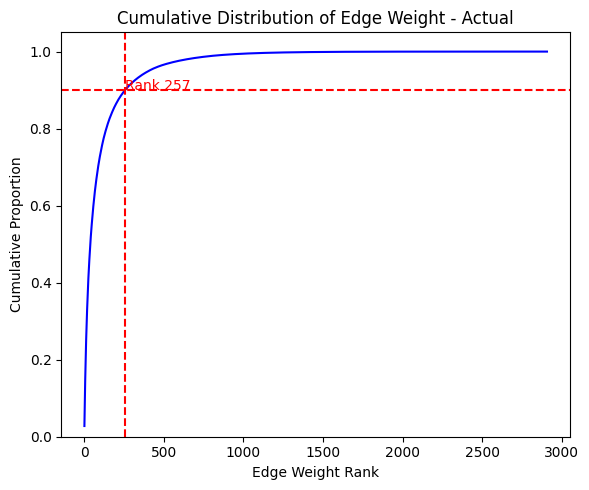

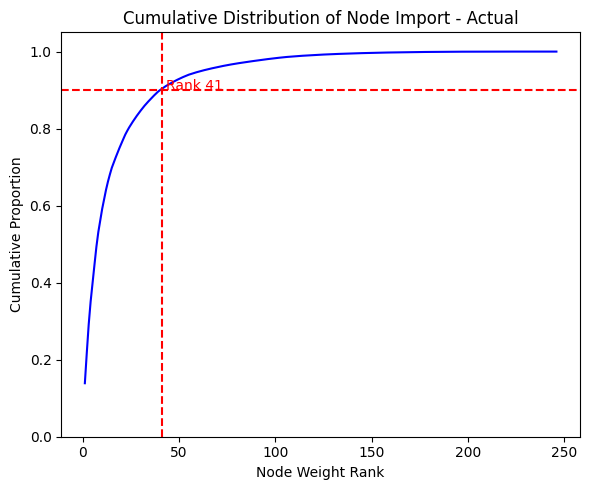

Edges after pruning (Actual): 256
Total nodes after pruning: 73


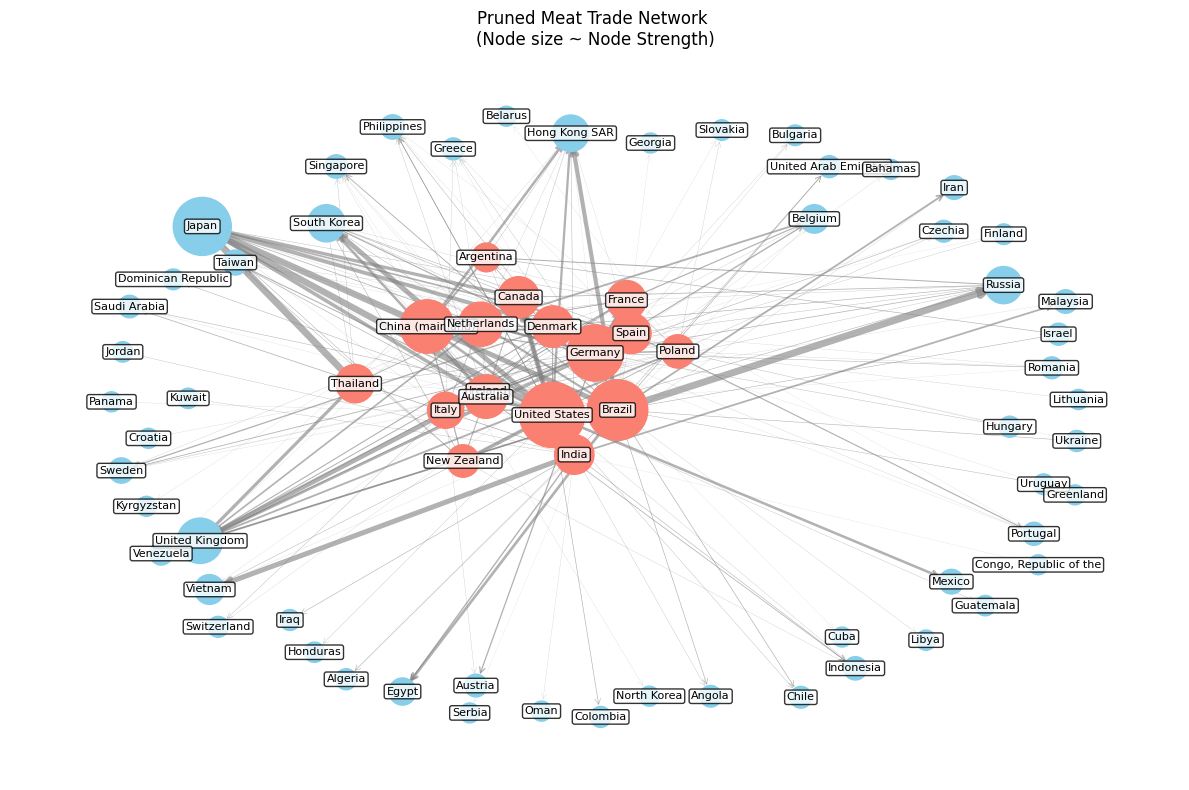

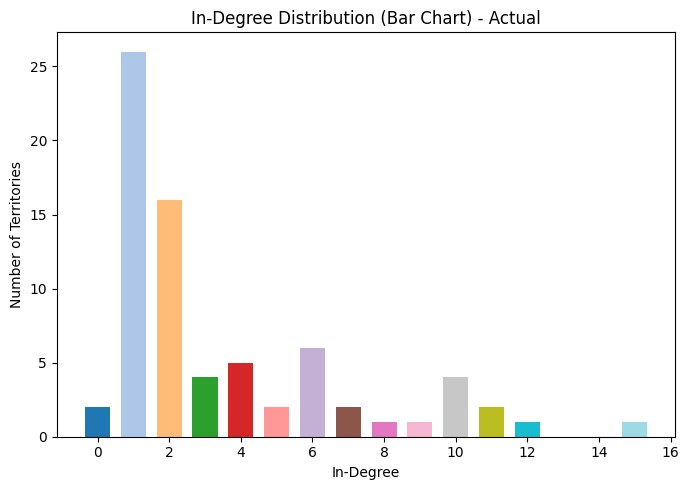

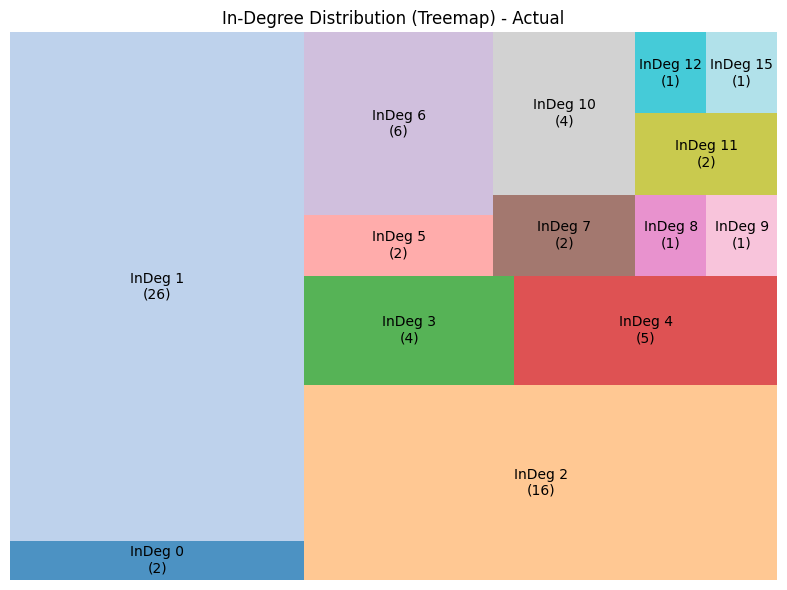


Out-Degree Table for Major Exporters - Actual
  Major Exporter  Out-degree
          Brazil          30
         Germany          27
           Spain          20
   United States          20
     Netherlands          19
         Denmark          17
          Poland          17
           India          16
       Australia          14
           Italy          14
          France          12
        Thailand           9
China (mainland)           9
         Ireland           9
          Canada           8
     New Zealand           8
       Argentina           7

In-Degree Table for Major Importers - Actual
  Major Importer  In-degree
           Japan         15
China (mainland)         12
     South Korea         11
  United Kingdom         11
   United States         10
   Hong Kong SAR         10
         Germany         10
     Netherlands         10
          Russia          9
          France          8


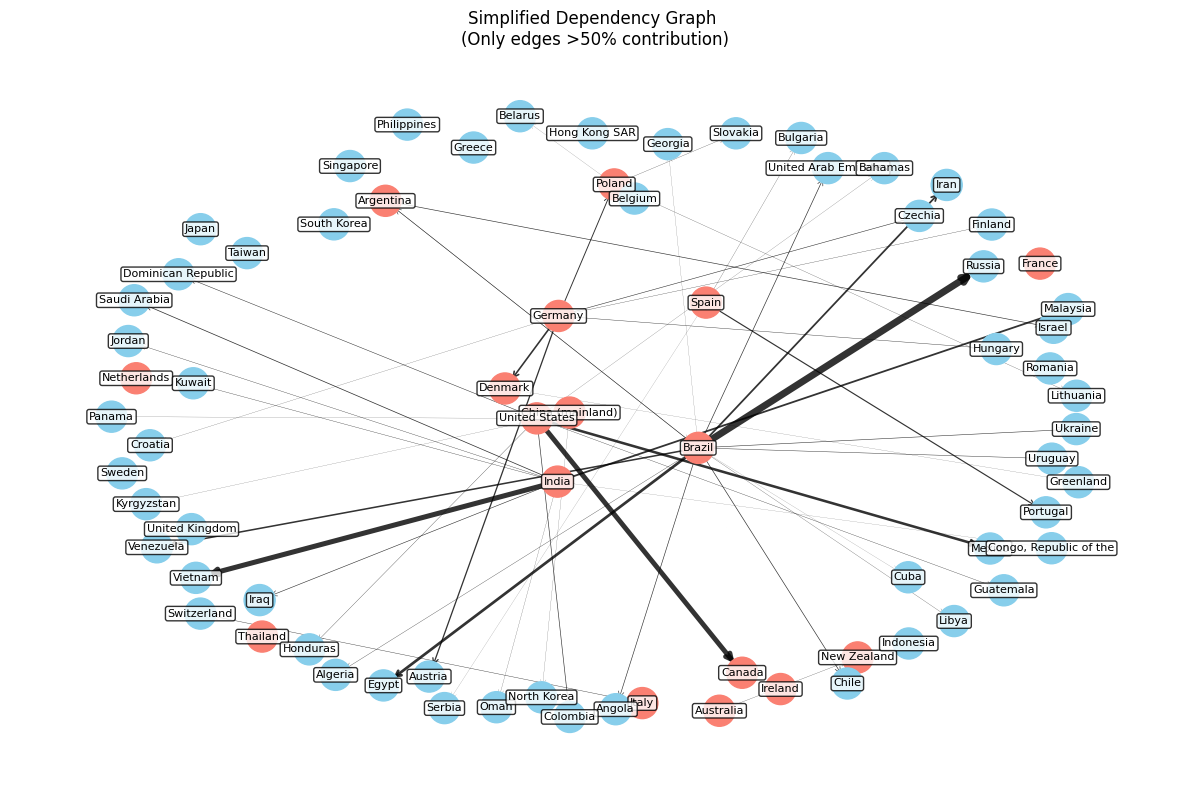


Dependency Table (>50% threshold) - Actual
Major Exporter       Dependent Importers
Argentina            Brazil, Israel
Australia            New Zealand
Brazil               Algeria, Angola, Argentina, Chile, Cuba, Egypt, Georgia, Iran, Libya, Russia, Ukraine, United Arab Emirates, Uruguay, Venezuela
China (mainland)     Kyrgyzstan, North Korea
Denmark              Greenland
Germany              Austria, Croatia, Czechia, Denmark, Finland, Hungary, Poland
India                Congo, Republic of the, Iraq, Jordan, Kuwait, Malaysia, Oman, Saudi Arabia, Vietnam
Italy                Switzerland
Poland               Belarus, Lithuania, Slovakia
Spain                Bulgaria, Portugal, Serbia
United States        Bahamas, Canada, Colombia, Dominican Republic, Guatemala, Honduras, Mexico, Panama

Centrality Measures (first few rows):
                      Node  Closeness  Betweenness  Eigenvector  PageRank
0                   Brazil      0.014        0.006        0.000     0.012
1           

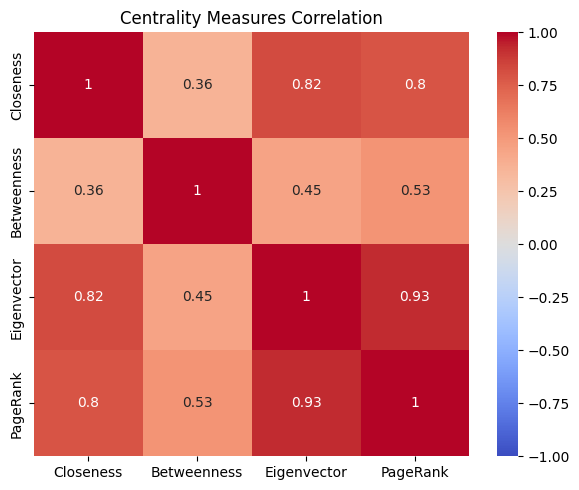

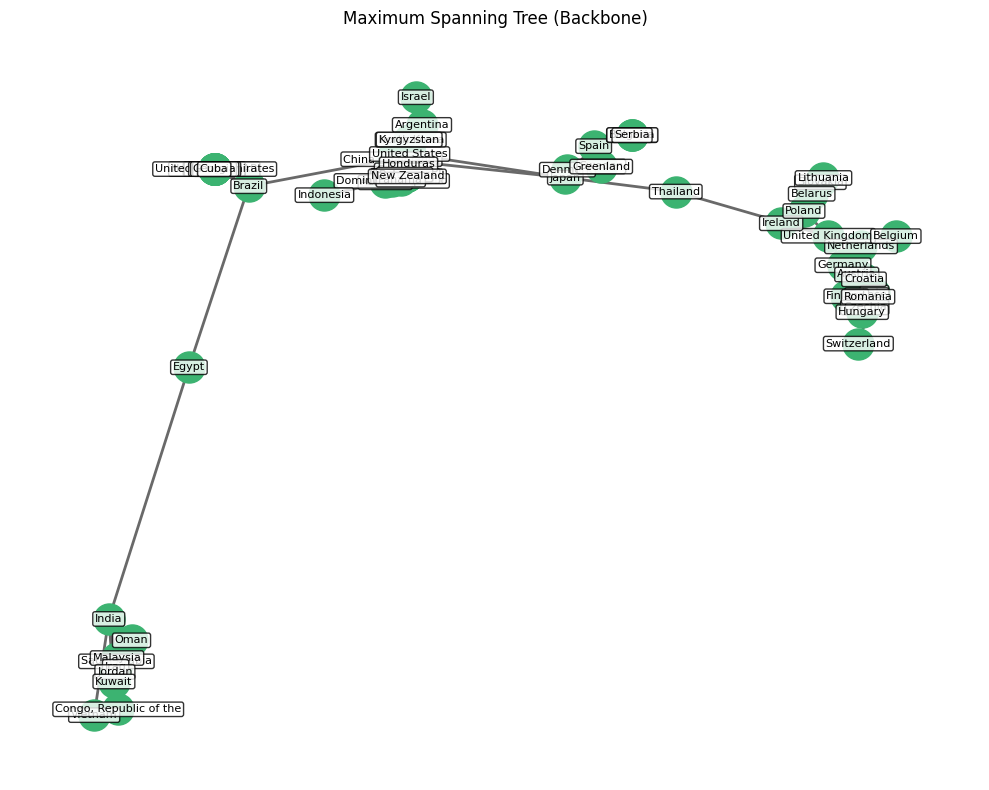

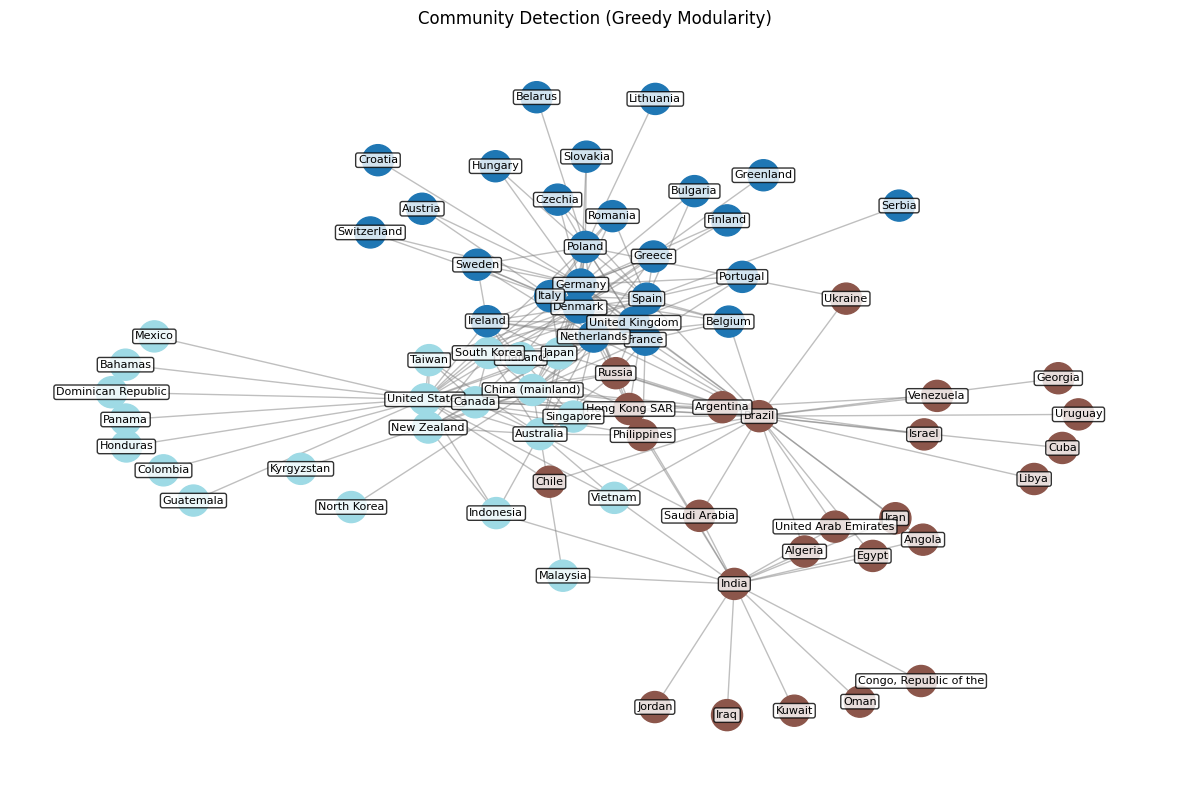

Removing top 5 nodes by eigenvector centrality in Actual: ['Japan', 'United Kingdom', 'South Korea', 'China (mainland)', 'Netherlands']
Largest connected component size before removal: 73
Largest connected component size after removal: 66
Removing top 5 nodes by out-degree: ['Brazil', 'Germany', 'United States', 'Spain', 'Netherlands']
Largest connected component size before removal: 73
Largest connected component size after removal: 53


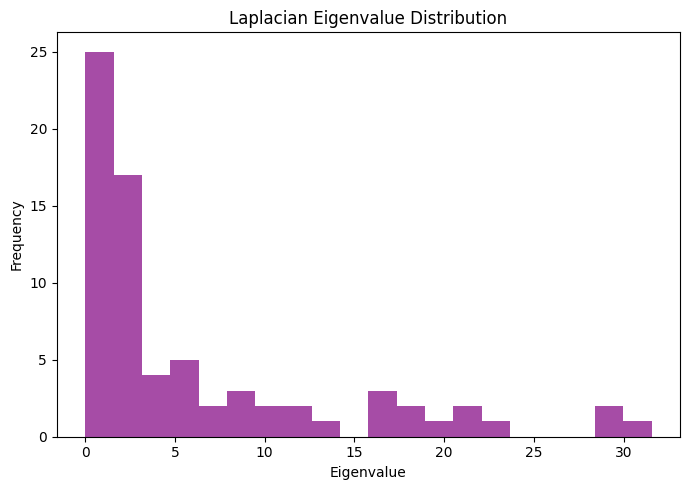

In [64]:
############################################################################
# Main Analysis: Run for Actual and Forecast Data
############################################################################

def main_analysis(actual_df, forecast_df):
    print("===== ANALYSIS FOR ACTUAL DATA =====")
    G_actual, df_cent = run_analysis_pipeline(actual_df, dataset_label="Actual")
    # if not forecast_df.empty:
    #     print("\n===== ANALYSIS FOR FORECAST DATA =====")
    #     G_forecast = run_analysis_pipeline(forecast_df, dataset_label="Forecast")
    # else:
    #     print("No forecast data to analyze.")
    return df_cent

df_cent = main_analysis(actual_df, forecast_df)

In [50]:
df_cent

,Node,Closeness,Betweenness,Eigenvector,PageRank
0,Brazil,0.014,0.006,0.000,0.012
1,Russia,0.155,0.000,0.194,0.019
2,Thailand,0.000,0.000,0.000,0.011
3,Japan,0.209,0.000,0.345,0.026
4,China (mainland),0.174,0.030,0.251,0.022
5,United States,0.156,0.033,0.167,0.021
6,India,0.000,0.000,0.000,0.011
7,Vietnam,0.115,0.000,0.046,0.013
8,South Korea,0.169,0.000,0.279,0.023
9,Canada,0.104,0.002,0.049,0.015
